## Multi-class Model Development with PWM

> Written by Jess Breda August 2023

For this notebook, I'm going to focus on fitting a single animal (W065) since they are "trained" before the violations stopped being tracked, and they have 50K trials pre-violation cutoff. See `create_violation_dataset.ipynb` for supporting figures

In [19]:
import pathlib
import platform

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

from scipy.optimize import minimize
from sklearn.model_selection import KFold, train_test_split

MODE = "local"

### Data Load 

In [2]:
if platform.system() == "Windows":
    DATA_PATH = pathlib.Path("X:\jbreda\learning_project\data")
else:
    if MODE == "cup":
        DATA_PATH = pathlib.Path("/Volumes/brody/jbreda/learning_project/data")
    elif MODE == "local":
        DATA_PATH = pathlib.Path("/Users/jessbreda/Desktop/github/animal-learning/data")
F_NAME = "processed/violation_data.csv"
ANIMAL_ID = "W065"

In [20]:
RAT_DF = pd.read_csv(DATA_PATH / F_NAME)
df = RAT_DF.query("animal_id == @ANIMAL_ID").reset_index().copy()

### Create Design Matrix

In [4]:
# def create_features_and_targets(df, animal_id, n_trials):
#     animal_df = df.query("animal_id == @animal_id").copy()
#     animal_df = animal_df[:n_trials]

#     X = pd.DataFrame()

#     return X, y

In [21]:
X = pd.DataFrame()

# normalize sa/sb to standard normal
X["s_a"] = (df.s_a - df.s_a.mean()) / df.s_a.std()
X["s_b"] = (df.s_b - df.s_b.mean()) / df.s_b.std()

# determine session boundaries
session_boundaries_mask = df["session"].diff() == 0

# get average stimulus loudness from previous trial (if exists)
X["s_avg"] = df[["s_a", "s_b"]].shift().mean(axis=1)
X["s_avg"] = (X.s_avg - X.s_avg.mean()) / X.s_avg.std()
X["s_avg"] = X.s_avg * session_boundaries_mask

# prev correct side (L, R) (0, 1) -> (-1, 1) [h in psytrack]
X["prev_correct"] = (df["correct_side"] * 2 - 1).astype(int).shift()
X["prev_correct"] = X.prev_correct * session_boundaries_mask

X.fillna(0, inplace=True)
X.insert(0, "bias", 1)

# prev choice- idk!

Y = pd.get_dummies(df["choice"], "choice", dummy_na=True).to_numpy(copy=True)

In [7]:
X.shape, Y.shape

((50105, 5), (50105, 3))

In [ ]:
## NICKS CODE
df = df[:first]  # restrict to "first" trials of data
# remove sessions with fewer than "cutoff" valid trials
df = df.groupby('session').filter(lambda x: len(x) >= cutoff)   

# Normalize the stimuli to standard normal
s_a = (df["s_a"] - np.mean(df["s_a"]))/np.std(df["s_a"])
s_b = (df["s_b"] - np.mean(df["s_b"]))/np.std(df["s_b"])

# Determine which trials do not have a valid previous trial (mistrial or session boundary)
t = np.array(df["trial"])
prior = ((t[1:] - t[:-1]) == 1).astype(int)
prior = np.hstack(([0], prior))

# Calculate previous average tone value
s_avg = (df["s_a"][:-1] + df["s_b"][:-1])/2
s_avg = (s_avg - np.mean(s_avg))/np.std(s_avg)
s_avg = np.hstack(([0], s_avg))
s_avg = s_avg * prior  # for trials without a valid previous trial, set to 0

# Calculate previous correct answer
h = (df["correct_side"][:-1] * 2 - 1).astype(int)   # map from (0,1) to (-1,1)
h = np.hstack(([0], h))
h = h * prior  # for trials without a valid previous trial, set to 0

# Calculate previous choice
c = (df["choice"][:-1] * 2 - 1).astype(int)   # map from (0,1) to (-1,1)
c = np.hstack(([0], c))
c = c * prior  # for trials without a valid previous trial, set to 0

### Fit Data

In [10]:
## Function for Multi-class Logistic Regression
def log_sum_exp(logits):
    """
    Compute the log of the sum of exponentials in a
    numerically stable way by subtracting off the largest
    logit.
    """
    max_logits = np.max(logits, axis=1, keepdims=True)
    return (
        np.log(np.sum(np.exp(logits - max_logits), axis=1, keepdims=True)) + max_logits
    )


def stable_softmax(logits):
    # use log-sum-exp for numerical stability
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))

    # sum over classes & normalize
    sum_exp = np.sum(exp_logits, axis=1, keepdims=True)
    return exp_logits / sum_exp


def multiclass_logistic_cost(W, X, Y, sigma=None):
    """
    Compute the negative log-likelihood for multi-class
    logistic regression with L2 regularization (or MAP).

    params:
    ------
    W: Weights matrix of shape (D+1, C)
    X: Data matrix of shape (N, D+1)
    Y: One-hot encoded labels of shape (N, C)
    sigma : float (default: None)
        Standard deviation of Gaussian prior, if None
        no regularization is applied.

    Returns:
    - nll: Regularized negative log-likelihood
    """

    logits = X @ W

    if sigma:
        # print(f"running with {sigma}!")
        penalty = 1 / (2 * (sigma**2)) * np.trace(W[1:, :].T @ W[1:, :])
    else:
        penalty = 0
        # print("skipping sigma!")

    nll = (-np.sum(Y * logits) + np.sum(log_sum_exp(logits))) + penalty
    return nll


def multiclass_logistic_gradient(W, X, Y, sigma=None):
    """
    Compute the gradient of the negative log-likelihood for
    multi-class logistic regression with L2 regularization (or MAP).

    params:
    ------
    W: Weights matrix of shape (D+1, C)
    X: Data matrix of shape (N, D+1)
    Y: One-hot encoded labels of shape (N, C)
    sigma : float (default: None)
        Standard deviation of Gaussian prior, if None
        no regularization is applied.

    Returns:
    - gradient : Gradient of shape (D+1, C)
    """

    logits = X @ W
    P = stable_softmax(logits)

    if sigma:
        penalty_gradient = W / (sigma**2)
        penalty_gradient[0, :] = 0  # No penalty for bias
    else:
        penalty_gradient = 0

    gradient = X.T @ (P - Y) + penalty_gradient
    return gradient


def cost_function_to_minimize(W_flat, X, Y, sigma=None):
    W_matrix = W_flat.reshape(D + 1, C)
    return multiclass_logistic_cost(W_matrix, X, Y, sigma)


def gradient_function_to_minimize(W_flat, X, Y, sigma=None):
    W_matrix = W_flat.reshape(D + 1, C)
    grad_matrix = multiclass_logistic_gradient(W_matrix, X, Y, sigma)
    return grad_matrix.flatten()

In [8]:
N = len(X)
D = X.shape[1] - 1
C = Y.shape[1]

In [12]:
# Initial weights
initial_W_flat = np.zeros((D + 1) * C)
sigma = 0.2

# Optimization using L-BFGS-B
result = minimize(
    fun=cost_function_to_minimize,
    x0=initial_W_flat,
    args=(X.to_numpy(), Y, sigma),
    method="L-BFGS-B",
    jac=gradient_function_to_minimize,
    options={"disp": True, "maxiter": 10000},
)
optimized_W = result.x.reshape(D + 1, C)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50460D+04    |proj g|=  8.06550D+03

At iterate    1    f=  5.16365D+04    |proj g|=  5.71682D+03

At iterate    2    f=  4.97524D+04    |proj g|=  2.57935D+03

At iterate    3    f=  4.90532D+04    |proj g|=  1.44652D+03

At iterate    4    f=  4.86696D+04    |proj g|=  8.87372D+02

At iterate    5    f=  4.85901D+04    |proj g|=  4.66415D+02

At iterate    6    f=  4.85718D+04    |proj g|=  1.33511D+02

At iterate    7    f=  4.85697D+04    |proj g|=  3.90932D+01

At iterate    8    f=  4.85696D+04    |proj g|=  1.77883D+01

At iterate    9    f=  4.85695D+04    |proj g|=  1.48390D+01

At iterate   10    f=  4.85695D+04    |proj g|=  4.41245D+00

At iterate   11    f=  4.85695D+04    |proj g|=  1.60689D+00

At iterate   12    f=  4.85695D+04    |proj g|=  2.27370D-01

At iterate   13    f=  4.8

 This problem is unconstrained.


### Visualize

In [14]:
def plot_weight_differences(X, optimized_W):
    """
    Plot the differences between consecutive as bar charts.

    Parameters:
    - X: data frame of design matrix
    - optimized_W: weights obtained after optimization

    Returns:
    - plots the differences.
    """

    # Number of classes
    D_w_bias = optimized_W.shape[0]
    C = optimized_W.shape[1]

    # Prepare data for Seaborn
    diff_data = []
    for c in range(C - 1):
        differences = optimized_W[:, c] - optimized_W[:, c + 1]
        for i, diff in enumerate(differences):
            diff_data.append(
                {
                    "Difference": diff,
                    "Feature": X.columns[i],
                    "Pairing": f"Weights {c+1} - {c+2}",
                }
            )

    df_diff = pd.DataFrame(diff_data)

    # Plot using Seaborn
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x="Feature", y="Difference", hue="Pairing", data=df_diff, ax=ax)
    ax.axhline(y=0, color="black")
    plt.xticks(rotation=90)
    plt.legend(loc="upper right")


def plot_class_weights(X, optimized_W):
    """
    Plot the weights for each feature and class as bar charts.

    Parameters:
    - X: data frame of design matrix (N x D)
    - optimized_W: weights obtained after optimization (D x C)

    Returns:
    - plots the weights.
    """

    # Extract shape details
    D, C = optimized_W.shape
    classes = ["L", "R", "V"]

    # Prepare data for Seaborn
    weight_data = []
    for c in range(C):
        for d in range(D):
            weight_data.append(
                {
                    "Weight": optimized_W[d, c],
                    "Feature": X.columns[d],
                    "Class": classes[c],
                }
            )

    df_weights = pd.DataFrame(weight_data)

    # Plot using Seaborn
    plt.figure(figsize=(15, 6))
    sns.barplot(x="Feature", y="Weight", hue="Class", data=df_weights)
    plt.xticks(rotation=90)
    plt.legend(loc="upper right")
    plt.show()

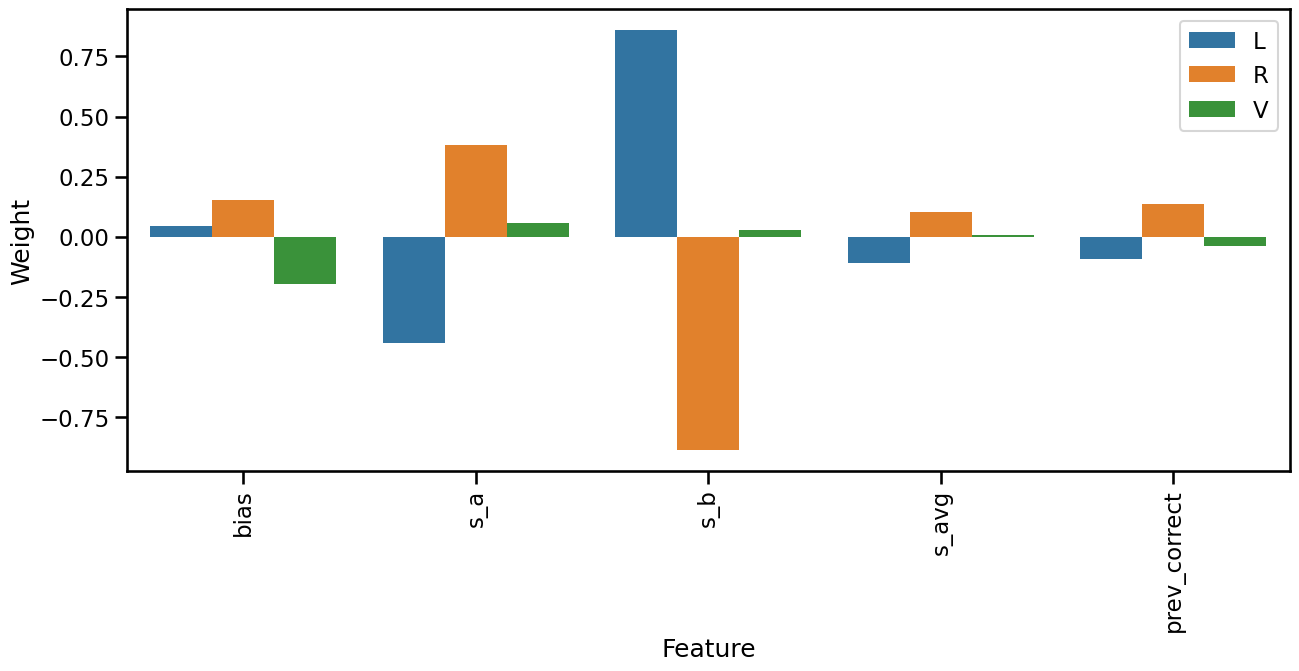

In [17]:
# Call the function
plot_class_weights(X, optimized_W)

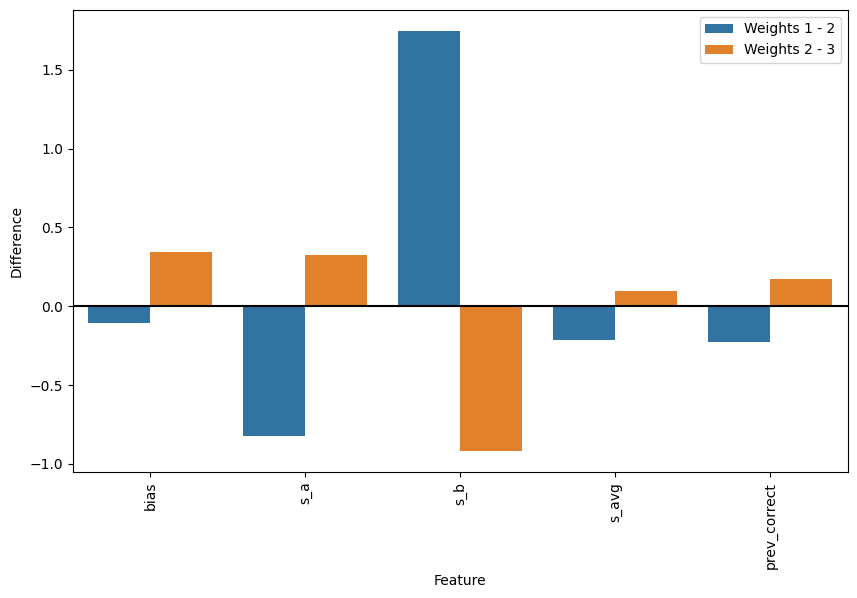

In [16]:
plot_weight_differences(X, optimized_W)